# Modelling

This notebook tests and describes the procedure to model the data.

## Preamble

In [1]:
# load basic libraries
import numpy as np
import os
import sys
import re
import pandas as pd
from importlib import reload

# load other libraries
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE

from gensim import corpora, models, similarities


# add ./python to python path
sys.path.insert(0, '../python')

# load local libraries
import cleaning
import text_processing
import modelling

## Options

In [9]:
# options
data_dir = '../Data/training'

# intermediate files to train
# and build the model
path_train = data_dir+'/train.csv'
path_test = data_dir+'/test.csv'

plt.style.use('seaborn-whitegrid')

plt.rc('pdf', fonttype=42)
sns.mpl.rc('figure', figsize = (10, 8))
sns.set_context('notebook', font_scale=2.0, rc={'lines.linewidth': 2.5})

pd.set_option('display.max_columns', 500)

## Data modelling

The steps below describe how to run the modelling workflow. First split the current into training and test sample to train the model, then perform training and testing.

In [10]:
# define a random state for reproductability
random_state = 20091982

### Training/test splitting

In [95]:
# set to True to generate the files
# set to False if the files already exist
if False:
    # first run the following command (or run in the terminal)
    ! ../python/main.py clean '../Data/23-08-2018/Export.txt' -sep ';'
    ! ../python/split.py '../Data/23-08-2018/Export_clean.csv' \
        '../Data/training/train.csv,../Data/training/test.csv'
    # we create a small train sample version for tests only
    ! ../python/resample.py  '../Data/training/train.csv' '../Data/training/train_small.csv' -n 1000

else:
    df_train = pd.read_csv('../Data/training/train.csv')
    df_test = pd.read_csv('../Data/training/test.csv')

### Training

The training phase will perform the following steps:
- build a dictionary from a csv file that contains the cleaned NOTAMs,
- vectorize the NOTAMs
- performs hierarchical clustering
- record cluster label and important/unimportant class

In [192]:
def run_tests(vectorize_method, cluster_method, n_dim, path_train, path_test):
    """Train and test vectorize and cluster models"""

    path_model = '../Data/training/train_model_vectorize_{0}.pickle'.format(vectorize_method)
    path_model += ',../Data/training/train_model_cluster_{0}.pickle'.format(cluster_method)
        
    path_out_train = '{0}_{1}_{2}_cluster_purity.csv'.format(
            path_train.replace('.csv', ''), vectorize_method, cluster_method)

    path_out_test = '{0}_{1}_{2}_cluster_purity.csv'.format(
            path_test.replace('.csv', ''), vectorize_method, cluster_method)

    ! ../python/main.py train {path_train} \
        -vectorize_method {vectorize_method} -n_dim {n_dim} \
        -cluster_method  {cluster_method}\
        -path_model {path_model}
        
    ! ../python/main.py predict {path_train} \
        -vectorize_method {vectorize_method} \
        -cluster_method  {cluster_method}\
        -path_model {path_model} \
        -cluster_dist 'test' \
        -path_out {path_out_train}

    ! ../python/main.py predict {path_test} \
        -vectorize_method {vectorize_method} \
        -cluster_method  {cluster_method}\
        -path_model {path_model} \
        -cluster_dist 'test' \
        -path_out {path_out_test}
    
    return

In [224]:
# hyperparameters
AWS = True

n_dim = 50

if AWS:
    
    # to be run on big machine (Amazon Web Services)
    vectorize_methods = ['TFIDF-SVD', 'TFIDF-NMF', 'BOW-SVD', 'BOW-LDA', 'word2vec']
    cluster_methods = ['hierarch_cosine_average', 'hierarch_euclid_ward']

    path_train = '../Data/training/train.csv'
    path_test = '../Data/training/test.csv'

else:

    # to be run on local machine for tests
    vectorize_methods = ['TFIDF-NMF']
    cluster_methods = ['hierarch_cosine_average']

    # path_train = '../Data/training/train_small.csv'
    # path_test = '../Data/training/train_small.csv'
    path_train = '../Data/training/test.csv'

for vectorize_method in vectorize_methods:
    for cluster_method in cluster_methods:
        run_tests(
            vectorize_method, cluster_method, 
            n_dim, path_train, path_test)



Task: train.

Output model paths:
vectorize:../Data/training/train_model_vectorize_TFIDF-NMF.pickle
cluster:../Data/training/train_model_cluster_hierarch_cosine_average.pickle

Reading file...done (found 19710 NOTAMs).
Vectorizing NOTAMs (method:TFIDF-NMF, n_dim:50)...done.
Training clusters (method:hierarchical, options:{'method': 'average', 'metric': 'cosine'})...done.


In [221]:
with open('/tmp/vector.pickle', 'rb') as file_in:
    vector = pickle.load(file_in)            
vector_corrected = vector.copy()

In [223]:
#zeros = np.sum(vector, axis=1) == 0
vector_corrected[zeros, :] = np.zeros(vector.shape[1])+99.0

#df_test[zeros]['fulltext'].iloc[3]
#np.sum(np.sum(vector, axis=1) == 0.)
Z = linkage(vector_corrected, **{'metric': 'cosine', 'method': 'average'})


In [180]:
vectorize_method = 'BOW-SVD'
cluster_method = 'hierarch_cosine_average'

path_model = '../Data/training/train_model_vectorize_{0}.pickle'.format(vectorize_method)
path_model += ',../Data/training/train_model_cluster_{0}.pickle'.format(cluster_method)




In [142]:
vectorize_method = 'BOW-SVD'
cluster_method = 'hierarch_cosine_average'

path_model = '../Data/training/train_model_vectorize_{0}.pickle'.format(vectorize_method)
path_model += ',../Data/training/train_model_cluster_{0}.pickle'.format(cluster_method)
! ../python/main.py predict '../Data/training/test.csv' \
    -path_model {path_model} \
    -cluster_dist 'guess'


Task: predict.

Input model paths:
vectorize:../Data/training/train_model_vectorize_BOW-SVD.pickle
cluster:../Data/training/train_model_cluster_hierarch_cosine_average.pickle

Reading file...done (found 19710 NOTAMs).
Vectorizing NOTAMs...done.
Predicting clusters...done.
Writting file...done.


In [30]:


# options
vectorize_method = 'TFIDF-SVD'

path_model_cluster = data_dir+'/model_cluster.pickle'

In [31]:
# takes into account changes
# made in the modelling.py file
reload(modelling)

# create model training object
model_train = modelling.ModelTraining(path_train)

Reading file...done (found 78837 NOTAMs).


In [32]:
# vectorize the NOTAMs, do
# dimensionality reduction
# and persist model (e.g.
# dictionary for BOW or TF-IDF)
model_train.vectorize(method=vectorize_method)

# train and persist clusters
# can be memory intensive
# here we take a subsample (10000) 
# for testing purposes only
model_train.cluster_train(
    path_out=path_model_cluster,
    n_samples=10000, random_state=random_state)

# we run the prediction to get a label for
# each NOTAM in case the training was made using 
# a subsample (n_samples != None)
#model_train.cluster_predict(path_in=path_train_cluster_model)

Vectorizing NOTAMs...done.
Training (clusters)...

TypeError: linkage() got an unexpected keyword argument 'n_clusters'

In [8]:
# methods to get class attributes:

# - get the data frame
df_train = model_train.get_df()

# - get the dictionary:
vocabulary_dict = model_train.get_vocabulary_dict()

# - get the word vector
vector_train = model_train.get_vector()

# - get the target (important/unimportant)
target_train = model_train.get_df()['important'].values

# get the cluster labels
#labels_train = model_train.get_cluster_labels()

### Prediction

In [9]:
reload(modelling)

# create model training object
model_test = modelling.ModelPredict(path_test)

# vectorize the NOTAMs and do
# dimensionality reduction
model_test.vectorize(method=vectorize_method)

# cluster label prediction
model_test.cluster_predict(path_in=path_train_cluster_model)

Reading file...done (found 19710 NOTAMs).
Vectorizing the NOTAMs...done.
Performing dimensionality reduction...done.
Predicting (clusters)...

FileNotFoundError: [Errno 2] No such file or directory: '../0_data/training/NOTAM_train_clean_model_cluster.pickle'

In [10]:
# methods to get class attributes:

# - get the data frame with labels
df_test = model_test.get_df()

# - get the word vector
vector_test = model_test.get_vector()

# - get the target (important/unimportant)
target_test = model_test.get_df()['important'].values

# get the cluster labels
labels_test = model_test.get_cluster_labels()

AttributeError: 'ModelPredict' object has no attribute '_ModelPredict__cluster_labels'

In [11]:
len(labels_test)
np.unique(df_test['cluster_labels'])

NameError: name 'labels_test' is not defined

In [12]:
# compute t-SNE representation
# additional info can be
# found here https://distill.pub/2016/misread-tsne/

# drives the number of neighbours in t-SNE
perplexity = 100

# file to store the t-SNE results
path_test_TSNE = path_test.replace('.csv', '_TSNE_perp{}.csv'.format(perplexity))

# it takes about 30 mn so we save 
# the result to a file
if False:
    test_TSNE = modelling.tsne(vector_test, random_state=random_state, perplexity=perplexity)
    pd.DataFrame(test_TSNE).to_csv(path_test_TSNE)
else:
    test_TSNE = pd.read_csv(path_test_TSNE)[['0', '1']].values

In [13]:
reload(modelling)

# plot the t-SNE representation
path_test_html = path_test_TSNE.replace('.csv', '.html')
modelling.plot_clusters(
    test_TSNE, model_test.get_df()['important'], 
    text= model_test.get_df()['fulltext'],
    label_names={True:'Important', False:'Unimportant'},
    html_out=path_test_html,
    interactive=True)

Plotting 9045 points with label Unimportant
Plotting 10665 points with label Important


## Tests

The section performs a few tests.

### Vectorization

In [282]:
reload(modelling)

corpus = df_test['text_clean'].fillna('empty_NOTAM').values

vocabulary_dict = modelling.build_vocabulary(
    corpus, path=None, method='gensim')

In [348]:
n_dim = 50
texts = [text.lower().split() for text in corpus]
word_counts = [vocabulary_dict.doc2bow(text) for text in texts]

# model = models.LsiModel(word_counts, id2word=vocabulary_dict, num_topics=n_dim)
model = models.Word2Vec(texts, min_count=1, size=n_dim)

In [351]:
model.wv[texts[0][0]]


array([ 3.555353  ,  1.7259442 ,  1.6820179 , -0.47744572, -0.9793916 ,
       -0.02549709,  2.9213371 ,  0.03081643,  0.5836168 , -1.449808  ,
        0.27146548, -0.6681326 , -3.0219367 , -3.5430243 , -1.8609906 ,
        0.24446931, -0.23728828, -2.05912   ,  0.9002443 ,  1.5524095 ,
        0.64018476, -2.4610915 , -0.8214859 ,  0.5463176 , -2.133753  ,
       -3.0860906 ,  1.8256985 ,  0.45183465,  0.31427094,  0.942475  ,
        2.4101038 ,  1.8861362 ,  0.33938688, -0.37577665, -0.5150769 ,
        0.66844535, -1.2060258 ,  0.58622575, -3.9306266 ,  3.4121616 ,
        0.05985551, -1.7852651 ,  0.47545007, -0.8842026 ,  1.818948  ,
       -0.945362  , -0.5193853 ,  0.08405127, -2.7842941 , -1.3370295 ],
      dtype=float32)

In [325]:
n_samples = len(word_counts)
vector = np.zeros((n_samples, n_dim))
for i,wc in enumerate(word_counts):
    v = np.array(model[wc]) 
    vector[i, v[:, 0].astype(int)] = v[:, 1]  
    
    #break
#word_counts[0]

#(model.)
#model.wv[word_counts[0]]

In [326]:
vector[100]

array([ 0.00030648,  0.00568392,  0.00274077,  0.01054436,  0.04311701,
       -0.00748522,  0.02029484, -0.03604969,  0.07111568, -0.1108948 ,
       -0.05589123,  0.01028228, -0.00611628,  0.07706025, -0.051821  ,
        0.01117248,  0.12470021,  0.02974224,  0.00224867, -0.00370444,
        0.00063055,  0.09692867, -0.09730422, -0.04093781,  0.05718332,
        0.05998981, -0.06770279,  0.08207417,  0.10041183,  0.03402585,
       -0.02244847, -0.04591457,  0.07656183, -0.03893229,  0.10394084,
       -0.09230607,  0.01693319, -0.00240668,  0.20221275, -0.10883091,
        0.07571104,  0.02774281,  0.16811453,  0.00615174, -0.04572169,
        0.03549289, -0.16546997,  0.09365206, -0.06826806,  0.08461454])

In [355]:
reload(modelling)

# methods = ['BOW-SVD', 'BOW-LDA', 'TFIDF-SVD', 'TFIDF-NMF']
methods = ['word2vec']

# sanity checks
for method in methods:

    print('Method:', method)
        
    trained = modelling.vectorize(
            df_test, 
            method=method, n_dim=50,
            text_col_name='text_clean',
            random_state=random_state,
            do_train = True,
    )
    
    predicted = modelling.vectorize(
            df_test,
            method=method,
            text_col_name='text_clean',
            do_train = False,
    )

    assert(np.sum(trained-predicted != 0) == 0)

Method: word2vec
Vectorizing NOTAMs...done.
Vectorizing NOTAMs...done.


In [356]:
predicted

array([[ 2.57695007,  1.19192994,  1.34937978, ...,  0.39711073,
        -1.42727053, -1.91058981],
       [ 1.20840824,  0.66082448,  0.85104966, ...,  0.07122314,
        -0.13406399, -1.30617058],
       [ 2.19163752,  0.3957985 ,  0.95561725, ...,  0.00319235,
        -1.35520041, -1.15851629],
       ...,
       [ 3.18237472, -0.05975909,  0.72949934, ..., -0.10118979,
        -0.05748006, -1.64392757],
       [ 0.54387635,  0.06611127,  0.83518362, ..., -0.21504822,
        -0.6832636 ,  0.01289959],
       [ 1.24110568,  0.25989181,  0.30155078, ..., -0.47530311,
        -1.42021477, -1.22438359]])

### Hierarchical clustering

In [368]:
reload(modelling)

def vectorize_and_fit_clusters(
        df, method_vectorize='BOW-SVD', n_dim=50, 
        cluster_method_options_dict={'method': 'ward'}, 
        random_state=random_state,
        path_out=path_train_cluster_model):
    """Vectorise and find clusters given a dataframe"""

    vector = modelling.vectorize(
            df, method=method_vectorize, 
            text_col_name='text_clean', 
            n_dim=n_dim, 
            random_state=random_state,
    )
    
    # tests on local computer
    choice = np.random.randint(vector.shape[0], size=5000)
    
    # test on AWS
    # choice = range(len(vector.shape[0]))
    
    modelling.find_clusters_train(
        vector[choice],
        method='hierarchical',
        method_options_dict=cluster_method_options_dict, 
        path_out=path_out, 
        random_state=random_state)

    return



def vectorize_and_analyse_clusters(
        path_in, df_train, df_test, 
        random_state=random_state,
        method_vectorize='TF-IDF', n_dim=50):
    """First compute number of clusters 
    at each stage = how many clusters 
    were found with larger distance than d?
    
    Then label the clusters in the test set and 
    compute the purity of the clusters.
    """
    
    print('training')
    target_train = df_train['important'].values
    vector_train = modelling.vectorize(
            df_train, method=method_vectorize, 
            n_dim=n_dim, 
            random_state=random_state,
    )

    print('test')
    target_test = df_train['important'].values
    vector_test = modelling.vectorize(
            df_test, method=method_vectorize, 
            n_dim=n_dim,
            random_state=random_state,
    )


    # read model and vector
    with open(path_in, 'rb') as file_in:
        _, _, Z = pickle.load(file_in)
    
    # important/unimportant target class
    target_test = df_test['important'].values
    
    n_clusters_list = []
    f_pure_test_list = []
    f_pure_train_list = []

    d_min = np.log10(np.quantile(Z[:,2], 0.95))
    d_max = np.log10(max(Z[:,2]))

    for d in np.logspace(d_min, d_max, 30):
        n_clusters = sum(Z[:,2] > d)
        n_clusters_list.append(n_clusters)
        
        labels_train = modelling.find_clusters_predict(vector_train, path_in, dist=d)
        labels_test = modelling.find_clusters_predict(vector_test, path_in, dist=d)
      
        N, purity, f_pure_train = modelling.get_cluster_purity(labels_train, target_train)        
        f_pure_train_list.append(f_pure_train)

        N, purity, f_pure_test = modelling.get_cluster_purity(labels_test, target_test)        
        f_pure_test_list.append(f_pure_test)    
        
        print(n_clusters, 'n_clusters={0}, dist={1:.2f}, f_pure(train)={2:.2f} f_pure(test)={3:.2f}'.format(
            n_clusters, d, f_pure_train, f_pure_test))
                
    return f_pure_train_list, f_pure_test_list


In [378]:
reload(modelling)

# methods = ['BOW-SVD', 'BOW-LDA', 'TFIDF-SVD', 'TFIDF-NMF']

vectorize_and_fit_clusters(
    df_train, method_vectorize='BOW-LDA', n_dim=50, 
    cluster_method_options_dict={'method': 'average', 'metric': 'cosine'},
    path_out=path_train_cluster_model.replace('.pickle', '_BOW-LDA_cosine_average.pickle'))

if False:
    vectorize_and_fit_clusters(
        df_train, method_vectorize='TFIDF-SVD', n_dim=50, 
        cluster_method_options_dict={'method': 'average', 'metric': 'cosine'},
        path_out=path_train_cluster_model.replace('.pickle', '_TFIDF-SVD_cosine_average.pickle'))


    vectorize_and_fit_clusters(
        df_train, method_vectorize='TFIDF-NMF', n_dim=50, 
        cluster_method_options_dict={'method': 'average', 'metric': 'cosine'},
        path_out=path_train_cluster_model.replace('.pickle', '_TFIDF-NMF_cosine_average.pickle'))


    vectorize_and_fit_clusters(
        df_train, method_vectorize='word2vec', n_dim=50, 
        cluster_method_options_dict={'method': 'average', 'metric': 'cosine'},
        path_out=path_train_cluster_model.replace('.pickle', '_word2vec_cosine_average.pickle'))
    
    vectorize_and_fit_clusters(
        df_train, method_vectorize='BOW-SVD', n_dim=50, 
        cluster_method_options_dict={'method': 'average', 'metric': 'cosine'},
        path_out=path_train_cluster_model.replace('.pickle', '_BOW-SVD_cosine_average.pickle'))

Vectorizing NOTAMs...

/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


done.


In [379]:
reload(modelling)

f_pure_train_list, f_pure_test_list = vectorize_and_analyse_clusters(
    path_train_cluster_model.replace('.pickle', '_BOW-LDA_cosine_average.pickle'), 
    df_train, df_test,
    method_vectorize='BOW-LDA', n_dim=50
)

training
Vectorizing NOTAMs...

/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


done.
test
Vectorizing NOTAMs...

/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


done.
250 n_clusters=250, dist=0.32, f_pure(train)=0.52 f_pure(test)=0.52
234 n_clusters=234, dist=0.33, f_pure(train)=0.52 f_pure(test)=0.52
212 n_clusters=212, dist=0.35, f_pure(train)=0.53 f_pure(test)=0.53
191 n_clusters=191, dist=0.36, f_pure(train)=0.52 f_pure(test)=0.52
172 n_clusters=172, dist=0.37, f_pure(train)=0.52 f_pure(test)=0.52
151 n_clusters=151, dist=0.39, f_pure(train)=0.54 f_pure(test)=0.54
137 n_clusters=137, dist=0.40, f_pure(train)=0.54 f_pure(test)=0.54
118 n_clusters=118, dist=0.42, f_pure(train)=0.54 f_pure(test)=0.54
108 n_clusters=108, dist=0.44, f_pure(train)=0.53 f_pure(test)=0.53
91 n_clusters=91, dist=0.45, f_pure(train)=0.53 f_pure(test)=0.53
80 n_clusters=80, dist=0.47, f_pure(train)=0.54 f_pure(test)=0.54
69 n_clusters=69, dist=0.49, f_pure(train)=0.53 f_pure(test)=0.53
64 n_clusters=64, dist=0.51, f_pure(train)=0.53 f_pure(test)=0.53
57 n_clusters=57, dist=0.53, f_pure(train)=0.53 f_pure(test)=0.53
54 n_clusters=54, dist=0.55, f_pure(train)=0.53 f_pu

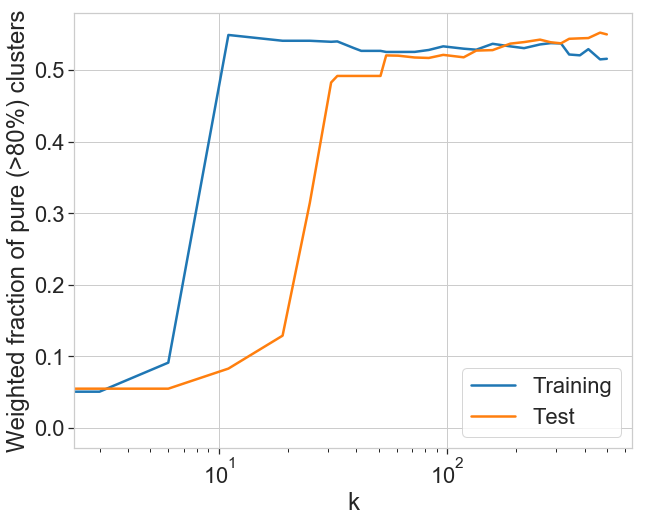

In [380]:
# BOW-LDA
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_train_list, label='Training')
ax.plot(n_clusters_list, f_pure_test_list, label='Test')
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')
ax.legend(frameon=True)

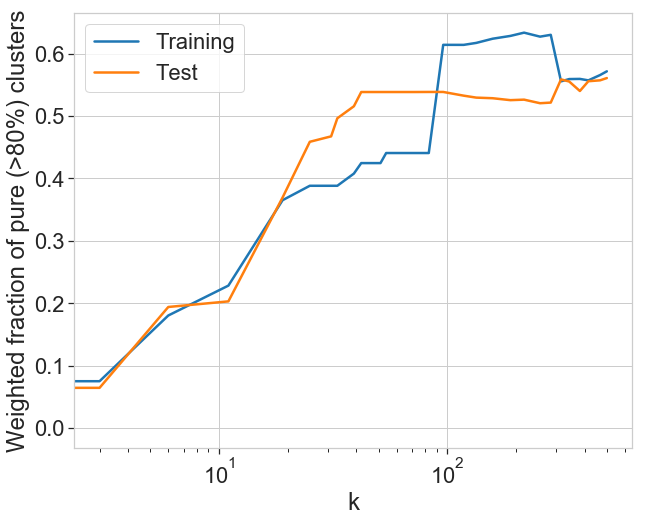

In [377]:
# TFIDF-NMF
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_train_list, label='Training')
ax.plot(n_clusters_list, f_pure_test_list, label='Test')
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')
ax.legend(frameon=True)

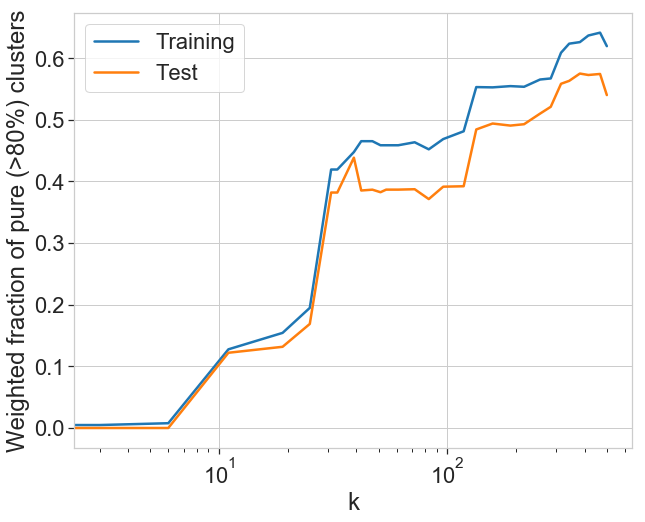

In [374]:
# TFIDF-SVD
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_train_list, label='Training')
ax.plot(n_clusters_list, f_pure_test_list, label='Test')
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')
ax.legend(frameon=True)

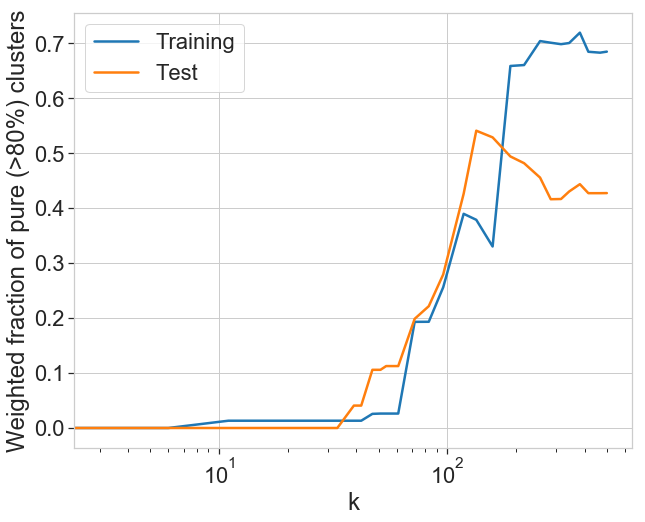

In [367]:
# word2vec
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_train_list, label='Training')
ax.plot(n_clusters_list, f_pure_test_list, label='Test')
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')
ax.legend(frameon=True)

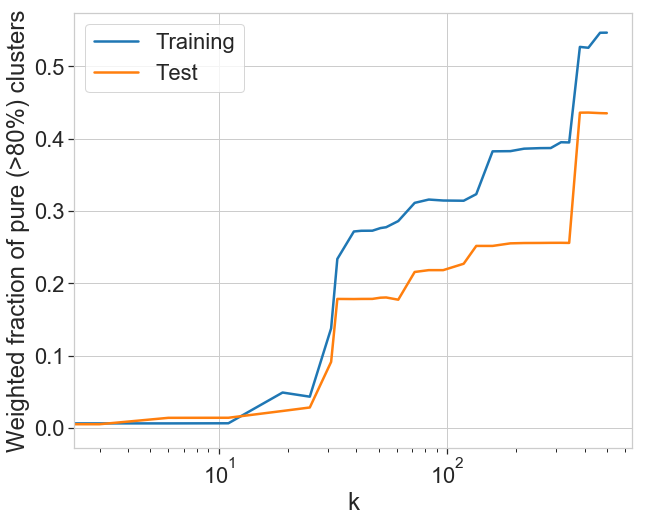

In [180]:
# BOW-SVD
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_train_list, label='Training')
ax.plot(n_clusters_list, f_pure_test_list, label='Test')
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')
ax.legend(frameon=True)

In [130]:
reload(modelling)

method_options_dict = {'method': 'average', 'metric': 'cosine'}


# read model
with open(path_train_cluster_model, 'rb') as file_in:
    _, Z = pickle.load(file_in)
Z.shape, target_train.shape

((9999, 4), (78837,))

((9999, 4), (78837,))

In [67]:
max(Z[:,2])

1.0001198276345138

0.26120476537066406

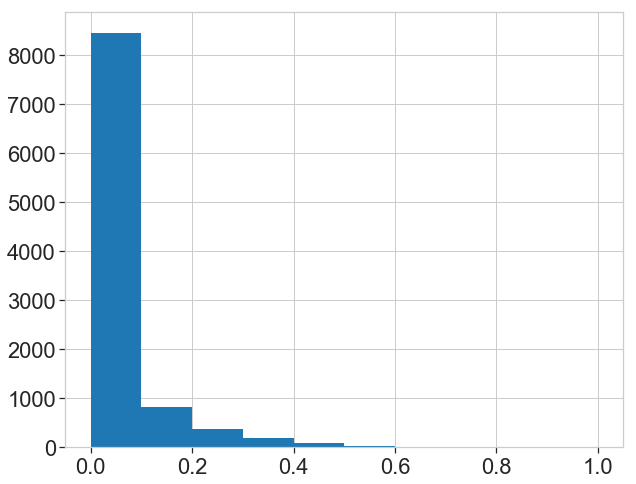

In [118]:
fig, ax = plt.subplots(figsize=(10, 8))

#ax.hist(Z[:,2])
#ax.hist(labels, bins=10)

#dn = dendrogram(Z, ax=ax)
#ax.tick_params(axis='y', which='major', labelsize=15)
#ax.grid(False)

#truncate_mode='lastp',  # show only the last p merged clusters
#p=12,  # show only the last p merged clusters
#leaf_rotation=90.,
#leaf_font_size=12.,
#show_contracted=True,  # to get a distribution impression in truncated branches
#)
None


500 0.25 0.67
467 0.26 0.67
415 0.27 0.66
381 0.29 0.65
342 0.30 0.64
315 0.32 0.65
284 0.33 0.65
255 0.35 0.63
217 0.37 0.61
189 0.38 0.69
158 0.40 0.68
134 0.42 0.68
118 0.44 0.55
96 0.47 0.56
83 0.49 0.59
72 0.51 0.52
61 0.54 0.52
54 0.56 0.50
51 0.59 0.50
47 0.62 0.49
42 0.65 0.47
39 0.68 0.45
33 0.72 0.47
31 0.75 0.46
25 0.79 0.47
19 0.83 0.24
11 0.87 0.18
6 0.91 0.01
3 0.95 0.01
0 1.00 0.00


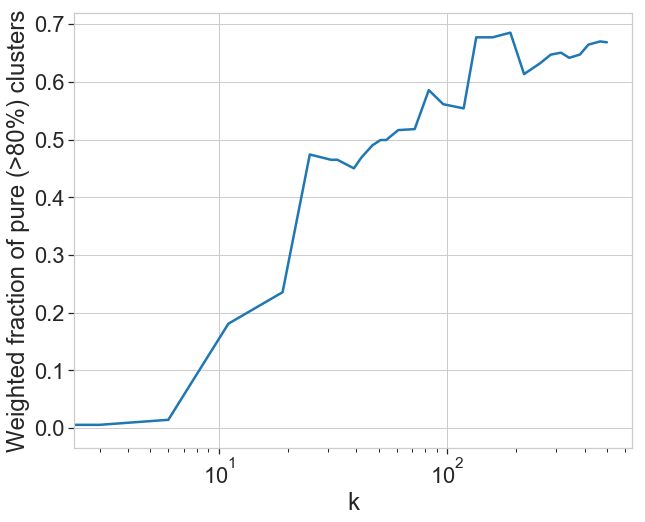

In [140]:
reload(modelling)

# then we compute number of clusters 
# at each stage, or:
# how many clusters are there with 
# larger distance than d?
n_clusters_list = []
f_pure_list = []
d_min = np.log10(np.quantile(Z[:,2], 0.95))
d_max = np.log10(max(Z[:,2]))

for d in np.logspace(d_min, d_max, 30):
    n_clusters = sum(Z[:,2] > d)
    n_clusters_list.append(n_clusters)
    labels = fcluster(Z, d, criterion='distance')
    N, purity, f_pure = modelling.get_cluster_purity(labels, target_train[choice])
    f_pure_list.append(f_pure)    
    print(n_clusters, '{0:.2f} {1:.2f}'.format(d, f_pure))


fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_list)
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')

In [103]:
df = pd.DataFrame.from_dict({'label':l, 'class':c})

0.6686

label
1      0.581818
2      0.000000
3      1.000000
4      0.977778
5      1.000000
6      0.000000
7      0.000000
8      0.666667
9      1.000000
10     1.000000
11     0.250000
12     0.982906
13     1.000000
14     0.000000
15     0.025974
16     0.000000
17     0.010989
18     0.000000
19     1.000000
20     0.981132
21     0.000000
22     0.500000
23     0.545455
24     1.000000
25     1.000000
26     1.000000
27     0.000000
28     0.000000
29     0.000000
30     0.000000
         ...   
472    0.000000
473    0.500000
474    0.000000
475    1.000000
476    0.750000
477    1.000000
478    1.000000
479    1.000000
480    1.000000
481    0.695652
482    0.000000
483    1.000000
484    0.625000
485    0.000000
486    1.000000
487    1.000000
488    1.000000
489    0.000000
490    0.566038
491    0.833333
492    1.000000
493    0.000000
494    0.750000
495    0.894737
496    1.000000
497    0.000000
498    1.000000
499    0.700000
500    1.000000
501    1.000000
Length: 501, dtype

In [36]:
len(np.unique(labels))

52

In [ ]:
def cluster_purity(vector, target):
    """ Find the clusters
    and measure the purity
    """

    # run hierachical clustering
    model_options_dict = {'n_clusters': k}
    model = modelling.find_clusters_train(
        vector[choice, :], model_type='hierarchical',
        model_options_dict=model_options_dict)
    
    labels = model.labels_
    classes = target[choice]

    N, purity, f_pure = modelling.get_cluster_purity(labels, classes)

    return N, purity, f_pure

### Line breaks for plotting

In [13]:
reload(modelling)

text_test = model_test.get_df()['text'].values
text_test_breaks = modelling.break_lines(text_test)

if True:
    for i in range(10):
        print(text_test[i])
        print(text_test_breaks[i])
        print()

TWY B BTN RWY 17R/35L AND TWY M CLSD
TWY B BTN RWY 17R/35L AND TWY M CLSD

MBST/WS DETECTION SYSTEM NOT AVBL
MBST/WS DETECTION SYSTEM NOT AVBL

RWY 07/25 CLSD Z POWODU WIP.
RWY 07/25 CLSD Z POWODU WIP.

DANGER AREA EYD9 PABRADE ACT
DANGER AREA EYD9 PABRADE ACT

TWY R BTN TWY S14 AND TWY R10 CLSD. TWY S16 CLSD.
TWY R BTN TWY S14 AND TWY R10 CLSD. TWY S16 CLSD.

RWY 32 RWY END ID LGT U/S
RWY 32 RWY END ID LGT U/S

TWY N BTN TWY R AND TWY C CLSD
TWY N BTN TWY R AND TWY C CLSD

RACER SEVEN DEPARTURE... BUTLER TRANSITION,SPRINGFIELD TRANSITION NA EXCEPT FOR AIRCRAFT EQUIPPED WITH SUITABLE RNAV SYSTEM WITH GPS. DOSOA TRANSITION DME REQUIRED EXCEPT FOR AIRCRAFT EQUIPPED WITH SUITABLE RNAV SYSTEM WITH GPS, BUM VORTAC U/S
RACER SEVEN DEPARTURE... BUTLER TRANSITION,SPRINGFIELD TRANS<br>ITION NA EXCEPT FOR AIRCRAFT EQUIPPED WITH SUITABLE RNAV SYS<br>TEM WITH GPS. DOSOA TRANSITION DME REQUIRED EXCEPT FOR AIRCR<br>AFT EQUIPPED WITH SUITABLE RNAV SYSTEM WITH GPS, BUM VORTAC <br>U/S

RWY 16/34 CLSD A

In [14]:
df = model_train.get_df()
df.head()

,folder_id,keyvalue,cat_id,svt,evt,validfromt,validtot,profcat,active,dataclass,wdays,rvt,rvid,crt,crid,source,vrnr,priority,spare,transcode,offical,supress,areaissued,notprefix,notserial,notyear,partno,notamcode,trafficind,notpurpose,notscope,minflt,maxflt,subj,briefingcard,printcat,IsNew,qsign,qstat,lat,lng,radius,severity,last_modified_dt,EstimatedEvt,item_id_1,fulltext,txt_id,HEX(id),text,text_clean,important
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4583789,-1,XXXX,3,2018-06-07 03:59:00.000,2038-01-01 00:00:00.000,0,0,2,1,TXT,127,2018-06-07 11:15:00.000,1677,2018-06-07 04:03:00.000,1,EUC,1,1,0,R,1,0,WRRR,WA,B4098,18,,QLFAS,I,BO,A,0,999,NaN,0,-1,0,NaN,NaN,-5110,84250,5,0,NaN,2018-09-06 08:00:00.000,4583789,B4098/18 NOTAMR B1528/18 Q)WAAF/QLFAS/I/BO/A/0...,11,0x00003F3F,SQFL (SEQUENCE FLASHING LIGHTS) RWY 16 U/S DUE...,sqfl sfl rwy <num> u s due to electrical pro...,True
4650267,-1,XXXX,5,2018-06-27 13:00:00.000,2018-06-28 19:00:00.000,0,0,2,1,TXT,127,2018-06-27 05:08:00.000,1698,2018-06-26 19:46:00.000,1,EUC,1,1,0,N,1,0,KZMA,KZ,A1037,18,,QRACA,I,NBO,W,0,999,NaN,0,-1,0,NaN,NaN,16580,-48730,24,0,NaN,NaN,4650267,A1037/18 NOTAMN Q)KZMA/QRACA/I/NBO/W/000/999/2...,11,0x00003F3F,AIRSPACE RESERVATION AVON HI COMPLEX ACT. MIAM...,airspace rsvn avon hi complex act miami cente...,True
4637946,2782,XXXX,3,2018-06-25 12:00:00.000,2018-06-28 21:00:00.000,0,0,2,0,TXT,127,2018-06-28 18:01:00.000,1302,2018-06-22 12:57:00.000,1,EUC,1,1,0,N,1,0,KMIA,KZ,A2005,18,,QMXHW,IV,M,A,0,999,NaN,0,-1,0,NaN,NaN,15480,-48170,5,0,NaN,NaN,4637946,A2005/18 NOTAMN Q)KZMA/QMXHW/IV/M/A/000/999/25...,11,0x00003F3F,TWY ALL WIP INSPECTION,twy all wip inspection,True
4624075,-1,XXXX,3,2018-06-19 07:50:00.000,2038-01-01 00:00:00.000,0,0,2,1,TXT,127,2018-06-19 10:14:00.000,1589,2018-06-19 08:10:00.000,1,EUC,1,1,0,R,1,0,OPKC,OP,A0588,18,,QMNHW,IV,BO,A,0,999,NaN,0,-1,0,NaN,NaN,18150,40160,5,0,NaN,2018-09-20 23:59:00.000,4624075,A0588/18 NOTAMR A0247/18 Q)OPLR/QMNHW/IV/BO/A/...,11,0x00003F3F,FOKKER/ATR APRON NOT AVBL DUE REHABILITATION WIP,fokker atr apron not avbl due rehabilitation wip,True
4612312,-1,XXXX,3,2018-06-13 10:28:00.000,2038-01-01 00:00:00.000,0,0,2,0,TXT,127,2018-08-11 09:24:00.000,1677,2018-06-15 08:04:00.000,1,EUC,1,1,1,R,1,0,HECA,HE,A0169,18,,QPDXX,I,NBO,A,0,999,NaN,0,-1,0,NaN,NaN,14380,19690,5,0,NaN,2019-09-01 08:00:00.000,4612312,A0169/18 NOTAMR A0254/17 Q)HECC/QPDXX/I/NBO/A/...,11,0x00003F3F,AIP SUP 15/14 EXTENDED.,aip sup <num> <num> extended,True


### Word counts

In [15]:
# word counts
# TODO: try 2-gram
# vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
vectorizer = CountVectorizer(stop_words='english')

# get the NOTAMS as a corpus
corpus = df['text_clean'].fillna('').values
word_counts = vectorizer.fit_transform(corpus)

In [16]:
# what are the typical words that appear most frequently?
print(word_counts.shape)
word_total_counts = word_counts.toarray().sum(axis=0)

# sorted indexes (most frequent first)
word_total_counts_sorted = -np.sort(-word_total_counts)
word_total_counts_sorted_ids = np.argsort(-word_total_counts)

(78837, 25419)


In [17]:
inverse_dictionary = {v:k for (k,v) in vectorizer.vocabulary_.items()}

### Most frequent words

In [18]:
n_most_frequent = 100
most_frequent = word_counts[:, word_total_counts_sorted_ids[:n_most_frequent]].toarray()

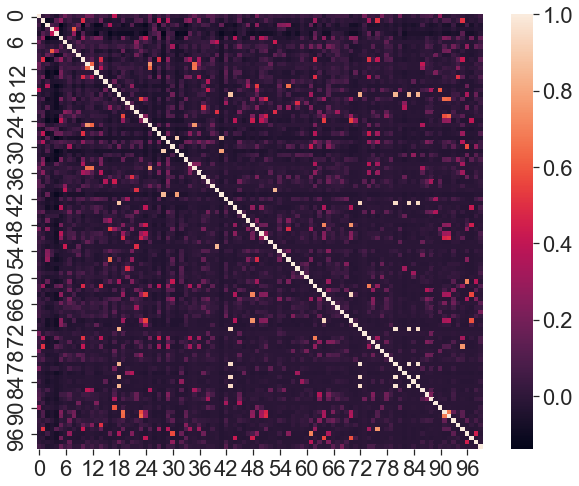

In [19]:
cov = np.corrcoef(most_frequent, rowvar=False)
sns.heatmap(cov)
None

In [20]:
feature_most_frequent = []
for index in word_total_counts_sorted_ids[:n_most_frequent]:
    feature_most_frequent.append(inverse_dictionary[index])
np.array(feature_most_frequent)

array(['num', 'coord', 'rwy', 'twy', 'clsd', 'area', 'fl', 'acft', 'btn',
       'avbl', 'wi', 'ft', 'nm', 'act', 'radius', 'ad', 'ils', 'aip',
       'gps', 'mil', 'mhz', 'dme', 'rte', 'flt', 'activated', 'amsl',
       'wip', 'airspace', 'wet', 'flw', 'exc', 'obs', 'svc', 'place',
       'km', 'fm', 'agl', 'vor', 'ref', 'sfc', 'dct', 'pct', 'info',
       'raim', 'restricted', 'rmk', 'maint', 'cat', 'radar', 'amdt',
       'tempo', 'atc', 'psn', 'ep', 'apch', 'lgt', 'loc', 'hr', 'freq',
       'ops', 'twr', 'rnav', 'circle', 'min', 'expect', 'proc', 'tfc',
       'ats', 'notam', 'opr', 'vectoring', 'danger', 'detection', 'end',
       'centre', 'ctl', 'line', 'jun', 'fir', 'point', 'fault', 'nr',
       'ch', 'tso', 'hours', 'outages', 'obst', 'alt', 'enr', 'ausots',
       'sup', 'civ', 'coor', 'dep', 'centered', 'points', 'equipped',
       'frng', 'departure', 'air'], dtype='<U10')

In [21]:
# most correlated words among top most frequent
indexes = np.unravel_index(np.argsort(-cov.ravel()), cov.shape)
select = (indexes[0] != indexes[1]) & (indexes[0] < indexes[1])

for i,j in zip(indexes[0][select][:100], indexes[1][select][:100]):
    print(
        feature_most_frequent[i].upper(),
        feature_most_frequent[j].upper(),
        '{:.2}'.format(cov[i,j]))

TSO OUTAGES 0.99
DETECTION FAULT 0.98
FAULT OUTAGES 0.98
FAULT TSO 0.98
DETECTION OUTAGES 0.96
DETECTION TSO 0.96
RAIM FAULT 0.95
RAIM OUTAGES 0.95
RAIM TSO 0.95
EXPECT VECTORING 0.94
RAIM DETECTION 0.94
WET OBS 0.91
GPS RAIM 0.88
WET PCT 0.85
DCT EP 0.85
GPS TSO 0.85
GPS OUTAGES 0.84
GPS FAULT 0.84
GPS DETECTION 0.82
OBS PCT 0.78
LINE POINTS 0.75
AMSL FM 0.75
FT AMSL 0.75
RADAR VECTORING 0.74
RADAR EXPECT 0.71
RNAV EQUIPPED 0.7
CIV COOR 0.69
CIRCLE CENTRE 0.69
NM FM 0.67
ILS LOC 0.66
FT FM 0.65
MIL CIV 0.65
FLT COOR 0.64
FT NM 0.64
NM AMSL 0.63
MIL COOR 0.63
TWY BTN 0.61
AIP SUP 0.6
VECTORING FRNG 0.59
FLT CIV 0.58
EXC EQUIPPED 0.57
MIL FLT 0.57
EXPECT FRNG 0.56
ACTIVATED VECTORING 0.56
ACTIVATED EXPECT 0.54
ILS AMDT 0.53
RTE DCT 0.51
COORD POINTS 0.51
WI CENTRE 0.51
RADIUS CENTERED 0.5
DME VOR 0.5
COORD LINE 0.5
WI AIRSPACE 0.5
RADIUS CIRCLE 0.5
RTE EP 0.49
MHZ FREQ 0.49
ATC COOR 0.49
WI RADIUS 0.49
COORD WI 0.49
AMDT LOC 0.48
MIL ATC 0.48
WI CIRCLE 0.48
ATC CIV 0.46
FLT ATC 0.45
EQU

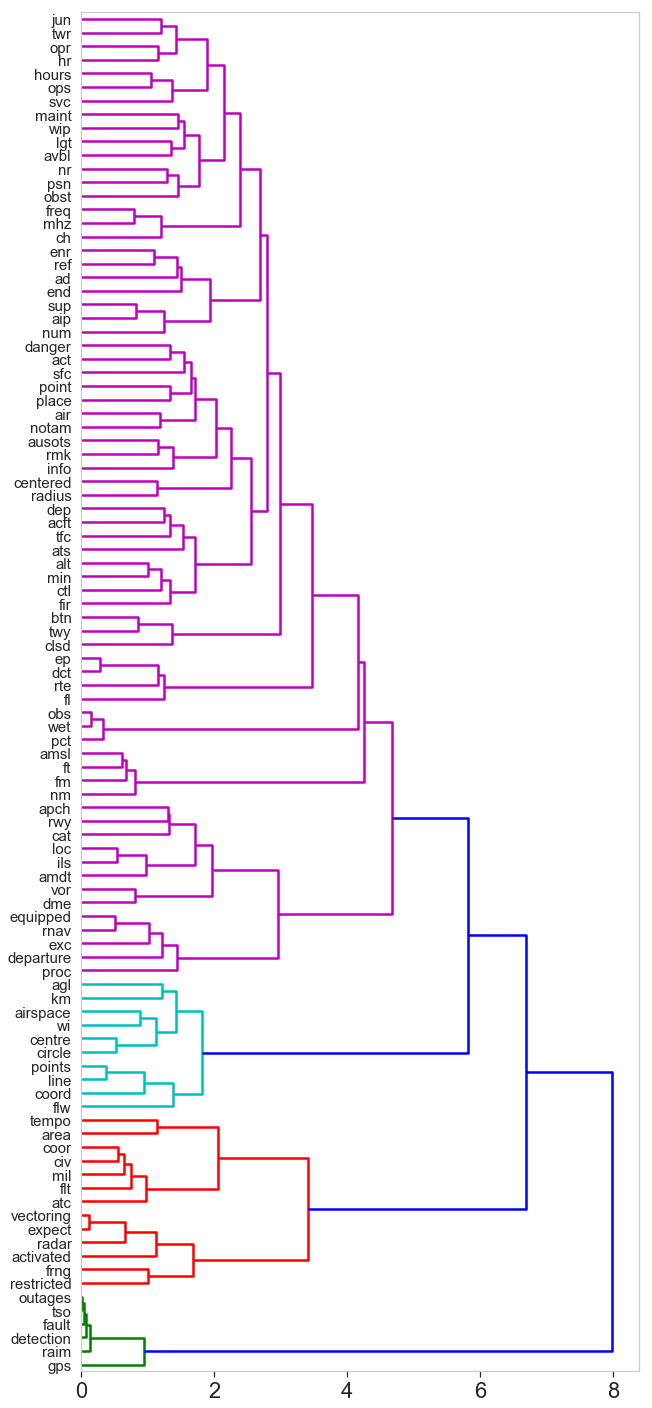

In [22]:
Z = linkage(cov, 'ward')
fig, ax = plt.subplots(figsize=(10, 25))
dn = dendrogram(Z, ax=ax, orientation='right', labels=feature_most_frequent)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.grid(False)

## NOTAM clustering

### K-means tests

We use the Elbow method to determine the number of typical clusters. 4 seems to be a good choice, but we see from the t-SNE projection that the clusters are not so relevant.

In [23]:
if False:
    inertia = []
    for k in range(1, 20):
        print(k)
        kmeans = KMeans(n_clusters=k, random_state=20091982)
        kmeans.fit(vector_train)
        inertia.append(kmeans.inertia_)

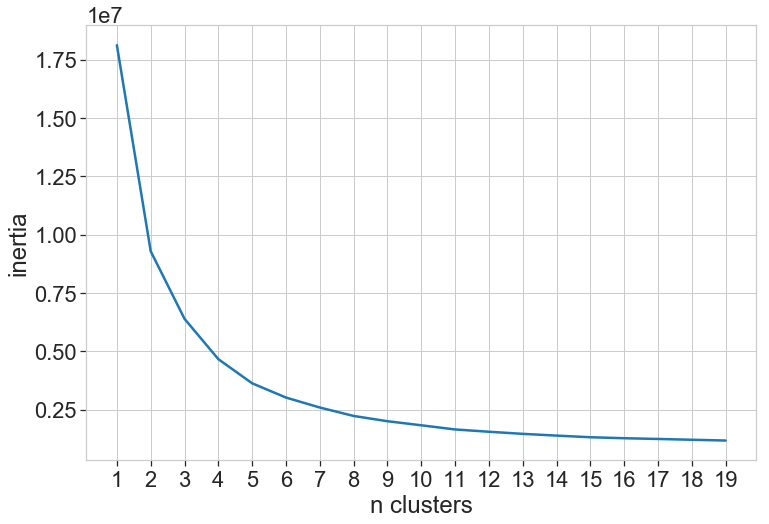

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(1, 20), np.array(inertia))
ax.set_xticks(range(1, 20))
ax.set_xlabel('n clusters')
ax.set_ylabel('inertia')
None

In [86]:
reload(modelling)

n_clusters = 50

# run K-means with n_clusters
path_out = data_dir+'/cluster_kmeans_k{}.pickle'.format(n_clusters)
model_options_dict = {'n_clusters': n_clusters, 'random_state': random_state}
model = modelling.cluster_train(
    vector_train, model_type='kmeans',
    model_options_dict=model_options_dict, path_out=path_out)

In [90]:
reload(modelling)

# evaluate test sample
labels_test = modelling.find_clusters_predict(vector_test, path_out, model_type='kmeans')

np.unique(labels_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 24, 25, 27, 29, 30, 31, 34, 35, 36, 39, 40,
       42, 45], dtype=int32)

In [91]:
reload(modelling)

# plot the t-SNE representation
path_tsne_html = path_tsne.replace('.csv', '_kmeans_k{}.html'.format(n_clusters))
modelling.plot_clusters(
    tsne_test, labels_test,
    text=model_test.get_df()['fulltext'],
    html_out=path_tsne_html,
    interactive=True)

Plotting 2684 points with label 0
Plotting 1 points with label 1
Plotting 23 points with label 2
Plotting 1 points with label 3
Plotting 564 points with label 4
Plotting 16 points with label 5
Plotting 57 points with label 6
Plotting 1 points with label 7
Plotting 182 points with label 8
Plotting 8 points with label 9
Plotting 1325 points with label 10
Plotting 1176 points with label 11
Plotting 3 points with label 12
Plotting 76 points with label 13
Plotting 260 points with label 14
Plotting 1 points with label 15
Plotting 9 points with label 16
Plotting 12 points with label 17
Plotting 12 points with label 18
Plotting 517 points with label 19
Plotting 57 points with label 20
Plotting 167 points with label 21
Plotting 108 points with label 22
Plotting 1129 points with label 24
Plotting 4 points with label 25
Plotting 27 points with label 27
Plotting 14 points with label 29
Plotting 10 points with label 30
Plotting 2670 points with label 31
Plotting 8169 points with label 34
Plotting 1

### Hierarchical clustering tests

We test the hierarchical clustering.

In [24]:
# first we compute the hierarchical
# clusters and distances
# we only use a sub set for
# this step as it is time consuming

choice = np.random.choice(len(vector_train), size=10000)
Z = linkage(vector_train[choice, :], 'ward')

In [25]:
# then we compute number of clusters 
# at each stage, or:
# how many clusters are there with 
# larger distance than d?
n_clusters_list = []
for d in np.logspace(0, 3, 30):
    n_clusters = sum(Z[:,2] > d)
    print(n_clusters, '{0:.2f}'.format(d))
    n_clusters_list.append(n_clusters)
    
n_clusters_list = np.unique(n_clusters_list)

2764 1.00
2400 1.27
2037 1.61
1638 2.04
1310 2.59
1037 3.29
810 4.18
624 5.30
479 6.72
371 8.53
277 10.83
209 13.74
154 17.43
112 22.12
84 28.07
65 35.62
48 45.20
35 57.36
26 72.79
18 92.37
13 117.21
13 148.74
9 188.74
8 239.50
4 303.92
3 385.66
3 489.39
2 621.02
2 788.05
1 1000.00


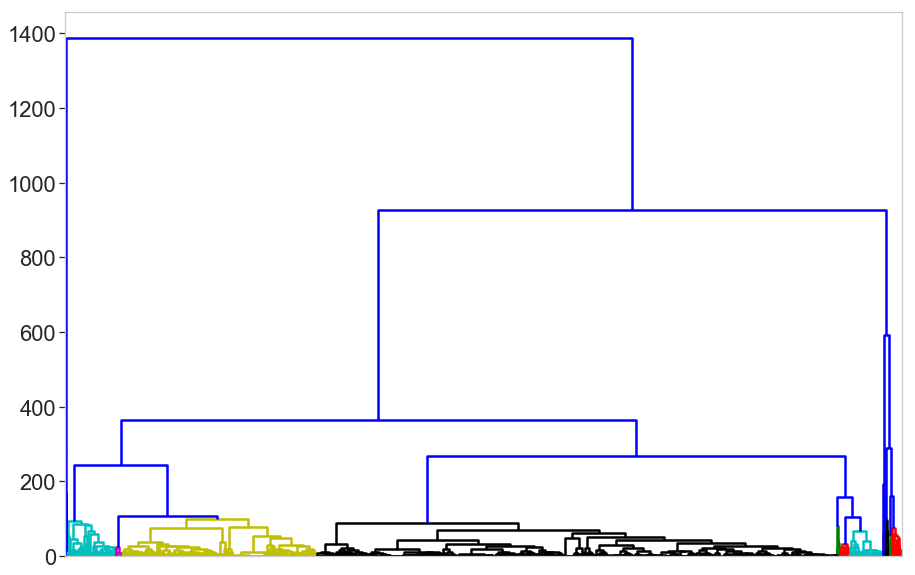

In [26]:
# visualize the clusters
fig, ax = plt.subplots(figsize=(15, 10))
dn = dendrogram(Z, ax=ax, no_labels=True, color_threshold=100)
ax.grid(False)
None

In [28]:
reload(modelling)

def cluster_purity_OLD(vector, target, k, size=5000):
    """ Find the clusters
    and measure the purity
    """

    choice = np.random.choice(len(vector_train), size=size)

    # run hierachical clustering
    model_options_dict = {'n_clusters': k}
    model = modelling.find_clusters_train(
        vector[choice, :], model_type='hierarchical',
        model_options_dict=model_options_dict)
    
    labels = model.labels_
    classes = target[choice]

    N, purity, f_pure = modelling.get_cluster_purity(labels, classes)

    return N, purity, f_pure

N_4, purity_4, f_pure_4 = cluster_purity(vector_train, target_train, 4, size=5000)
N_50, purity_50, f_pure_50 = cluster_purity(vector_train, target_train, 50, size=5000)

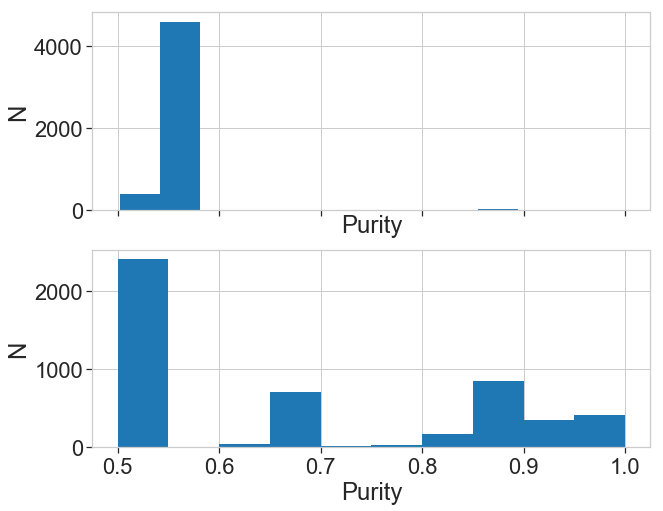

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].hist(purity_4, weights=N_4, bins=10)
ax[0].set_xlabel('Purity')
ax[0].set_ylabel('N')

ax[1].hist(purity_50, weights=N_50, bins=10)
ax[1].set_xlabel('Purity')
ax[1].set_ylabel('N')

None

In [71]:
f_pure_list = []
for k in n_clusters_list:
    N, purity, f_pure = cluster_purity(vector_train, target_train, k, size=10000)
    f_pure_list.append(f_pure)
    
    print(k, f_pure)

1 0.0
2 0.0007
3 0.0007
5 0.0014
6 0.0013
9 0.0509
11 0.0551
12 0.0502
18 0.0661
25 0.1494
34 0.1703
50 0.3774
65 0.4243
83 0.4358
110 0.4823
148 0.5063
203 0.553
276 0.5765
370 0.5731
477 0.5871
632 0.6051
798 0.6401
1051 0.6546
1331 0.7073
1653 0.6985
2063 0.7077
2419 0.7598
2783 0.812


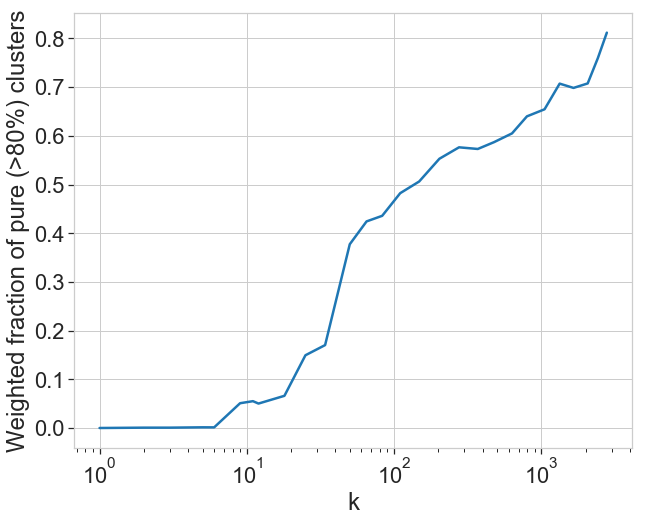

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(n_clusters_list, f_pure_list)
ax.set_xlabel('k')
ax.set_ylabel('Weighted fraction of pure (>80%) clusters')
ax.set_xscale('log')

In [40]:
reload(modelling)

# test with 50 clusters on the test sample
#choice = np.random.choice(len(vector_test), size=100)
choice = range(len(vector_test))

n_clusters = 50

# run hierachical clustering
path_out = data_dir+'/cluster_hierach_k{}.pickle'.format(n_clusters)
model_options_dict = {'n_clusters': n_clusters}
model = modelling.find_clusters_train(
    vector_test[choice, :], model_type='hierarchical',
    model_options_dict=model_options_dict, path_out=path_out)

In [41]:
reload(modelling)

# plot the t-SNE representation
path_tsne_html = path_test_TSNE.replace('.csv', '_hierach_k{}.html'.format(n_clusters))
modelling.plot_clusters(
    test_TSNE[choice, :], model.labels_,
    text=model_test.get_df()['fulltext'].iloc[choice],
    html_out=path_tsne_html,
    interactive=True)

Plotting 14 points with label 0
Plotting 316 points with label 1
Plotting 12 points with label 2
Plotting 3929 points with label 3
Plotting 353 points with label 4
Plotting 52 points with label 5
Plotting 10 points with label 6
Plotting 1698 points with label 7
Plotting 152 points with label 8
Plotting 4 points with label 9
Plotting 7 points with label 10
Plotting 1521 points with label 11
Plotting 3 points with label 12
Plotting 25 points with label 13
Plotting 108 points with label 14
Plotting 339 points with label 15
Plotting 1916 points with label 16
Plotting 18 points with label 17
Plotting 132 points with label 18
Plotting 6 points with label 19
Plotting 74 points with label 20
Plotting 922 points with label 21
Plotting 2992 points with label 22
Plotting 19 points with label 23
Plotting 6 points with label 24
Plotting 53 points with label 25
Plotting 15 points with label 26
Plotting 43 points with label 27
Plotting 139 points with label 28
Plotting 1 points with label 29
Plotting

### Training tests

In [43]:
# run on aws python/main.py train 0_Data/training/NOTAM_train_clean.csv
# and get /home/ubuntu/students/jean/swiss/0_Data/training/NOTAM_train_clean_model.pickle

path_in = path_train.replace('.csv', '_model.pickle')

# read model
with open(path_in, 'rb') as file_in:
    vector_train, labels_train = pickle.load(file_in)

In [86]:
# minimum fraction to keep a cluster
min_frac = 0.001 # 0.1%
n_samples = len(labels_train)
thres = int(n_samples*min_frac)

labels_train_new = labels_train.copy()
n_unlabelled = 0
count = 0
for l in np.unique(labels_train):
    select = labels_train == l
    n_select = sum(select)
    if n_select < thres:
        txt = df_train[select]['fulltext'].values[0]
        print(l, n_select, 'grouped with 0')
        n_unlabelled += 1
        labels_train_new[select] = 0
    else:
        count += 1
        labels_train_new[select] = count
        print(l, n_select)

print('n_unlabelled:', count)

0 38 grouped with 0
1 817
2 6 grouped with 0
3 288
4 71 grouped with 0
5 1071
6 28 grouped with 0
7 3058
8 1767
9 14 grouped with 0
10 97
11 877
12 871
13 57 grouped with 0
14 656
15 76 grouped with 0
16 9683
17 14291
18 156
19 20 grouped with 0
20 6 grouped with 0
21 8 grouped with 0
22 4202
23 14395
24 331
25 29 grouped with 0
26 2093
27 25 grouped with 0
28 522
29 5 grouped with 0
30 321
31 389
32 12137
33 118
34 1 grouped with 0
35 3 grouped with 0
36 20 grouped with 0
37 559
38 24 grouped with 0
39 207
40 1 grouped with 0
41 1 grouped with 0
42 585
43 1 grouped with 0
44 10 grouped with 0
45 101
46 59 grouped with 0
47 3171
48 4481
49 1090
n_unlabelled: 28


In [66]:
path_out = path_train.replace('.csv', '_model_no_small_clusters.pickle')
with open(path_out, 'wb') as file_out:
    pickle.dump((vector_train, labels_train_new), file_out)

In [69]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(vector_train, labels_train_new) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [70]:
labels_test = neigh.predict(vector_test)

In [105]:
reload(modelling)

# plot the t-SNE representation
path_tsne_html = path_test_TSNE.replace('.csv', '_hierach_k{}_test.html'.format(n_clusters))
modelling.plot_clusters(
    test_TSNE, labels_test,
    text=model_test.get_df()['fulltext'],
    html_out=path_tsne_html,
    interactive=True, emphasize_label=None)

Plotting 97 points with label 0
Plotting 179 points with label 1
Plotting 76 points with label 2
Plotting 327 points with label 3
Plotting 790 points with label 4
Plotting 14 points with label 6
Plotting 255 points with label 7
Plotting 171 points with label 9
Plotting 2704 points with label 10
Plotting 3821 points with label 11
Plotting 38 points with label 12
Plotting 1031 points with label 13
Plotting 3873 points with label 14
Plotting 86 points with label 15
Plotting 530 points with label 16
Plotting 51 points with label 18
Plotting 89 points with label 19
Plotting 3380 points with label 20
Plotting 83 points with label 24
Plotting 22 points with label 25
Plotting 39 points with label 26
Plotting 2054 points with label 27


## Cluster labelling

* label: 0, 'long'. This label is built from gathering hierarchical clusters with very few members (less than 0.1%). It appears most NOTAMs have in common a long enumeration of dates or coordinates but not systematically.
* label: 1, 'multiple_1'. Unclear structure, a few long texts as well. A few subgroup with clearer meanings such as military operations or construction/maintenance.
* label: 2, 'Multiple area restrictions'. Mixed cluster as well, but features a lot of area restrictions, both in airspace and on the ground.
* label: 3, 'Unimportant restricted areas'. Relatively pure unimportant cluster. Restricted airspace. Messages from air services Australia.
* label: 4: 'multiple_2'. Another mixed structure. Balloons, paragliding/parachute warnings. A few GPS-linked warnings. Some closed routes.
* label: 5: 'empty'. No neighbors found in the test sample.
* label: 6: 'UK activated danger areas'. Mostly from the UK, starting with "The following..."
* label: 7: 'multiple_3'. Similar to 4, perhaps with shorter texts?
* label: 8: 'empty'. No neighbors found in the test sample.
* label: 9: 'air space closed / unimportant'. Relatively pure cluster of 'unimportant' NOTAMS describing Airspace closed (with coordinates), military exercise and flights.
* label 10: 'large cluster of multiple warnings'. Cluster with multiple topics. Very large. Unmanned aircraft, balloons. Route restrictions. A group about frequency restrictions. Flight levels instructions. Crane/obstacle group. A few closed aerodrome.
* label 11: 'Closed runways'. Pure important cluster. Contains a large group of 'RWY NUM CLSD' + reason, or unserviceable runway instruments and landing systems(ILS/ALS).
* label 12: 'multiple_4'. A few checklists, warnings about fire and rescue. Military training in the air. Close to label 0 (only a few messages) -> increase the threshold to gather small clusters?
* label 13: 'Closed taxiways with reason'. Pure important cluster. Closed taxiways with diverse reasons explained.
* label 14: largest cluster. Mostly important. Several distinct groups: wet aprons, all classified as important. Restricted/danger area; important or not depends on the reason. Frequency restrictions. Military helicopter/PJE exercises. Closed airspace (why not grouped with label 2?). Parking stands. A group of various NOTAMs.
* label 15: 'taxiway restrictions'. Pure important cluster.
* label 16: 'closed airspace 1'. Various important/unimportant labeling. Closed airspace, should it be grouped with "restricted areas"? Navigation warning. Volcanic ash. Military operations.
* label: 17: 'empty'. No neighbors found in the test sample.
* label 18: 'RAD . Route availability documents. Not clear what those are?
* label 19: 'closed airspace as follows'. Mostly important. More details given compared to label 16, but would it be better to group them together?
* label 20: . Another large cluster. Mostly important but a few subgroups with unimportant NOTAMs, especially one with danger area due to military flights: why are those classified as unimportant? Also a lot of subgroups with various topics. A distinct group of closed taxiways. Whey aren't those in the group 13? A group about aerodrome service hours.
* labels 21-23: 'empty'. No neighbors found in the test sample.
* labels 24: 'approach procedure'. Pure important (small) cluster.
* label 25: 'multiple_5'. Same as label 12: a few checklists, warnings about fire and rescue. Military training in the air. Close to label 0 (only a few messages) -> increase the threshold to gather small clusters?
* label 26: 'multiple_6'. Small cluster. No clear pattern. Same as label 12? Unknown eastern language.
* label 27: 'various'. distinct clusters. One is about "PCT" wet taxiways and mostly classified as unimportant. What's PCT? The other group is more diverse: some instrument-related NOTAMs with instructions, restricted areas for various reasons: tour de France, fireworks. Does the reason help to decide if important or not? Or the fact that the area is restricted is the main reason to keep the NOTAM?



## Vectorization tests

### TF-IDF

In [121]:
reload(modelling)
vector_train = modelling.vectorize(df_train, method='TF-IDF')

Vectorizing the NOTAMs...done.
Performing dimensionality reduction...done.


In [125]:
reload(modelling)

choice = np.random.choice(len(vector_train), size=5000)

train_small_TSNE = modelling.tsne(vector_train[choice,:], random_state=random_state, perplexity=perplexity)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 4.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.697s
[t-SNE] Iteration 50: error = 71.5679092, gradient norm = 0.0250743 (50 iterations in 18.670s)
[t-SNE] Iteration 100: error = 68.1739426, gradient norm = 0.0007368 (50 iterations in 14.672s)
[t-SNE] Iteration 150: error = 68.1265488, gradient norm = 0.0004196 (50 iterations in 16.009s)
[t-SNE] Iteration 200: error = 68.1179352, gradient norm = 0.0003852 (50 iterations in 16.323s)
[t-SNE] Iteration 250: error = 68.1082230, gradient norm = 0.00

In [131]:
reload(modelling)

path_tsne_html = 'cluster.html'
modelling.plot_clusters(
    train_small_TSNE, model_train.get_df()['important'].iloc[choice],
    text=model_train.get_df()['fulltext'].iloc[choice],
    html_out=path_tsne_html)

Plotting 2303 points with label False
Plotting 2697 points with label True


### word2vec

In [150]:
from gensim import corpora, models, similarities

In [134]:
reload(modelling)
vector_train = modelling.vectorize(df_train, method='word2vec')

In [141]:
vector_train[0]

['sqfl', 'sfl', 'rwy', '<num>', 'u', 's', 'due', 'electrical', 'problem']

In [145]:
dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/NOTAM.dict')  # store the dictionary, for future reference
print(dictionary)


2018-10-08 16:05:25,399 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-10-08 16:05:25,689 : INFO : adding document #10000 to Dictionary(10164 unique tokens: ['zae', 'embargo', 'windsock', 'victor', 'holdg']...)
2018-10-08 16:05:25,953 : INFO : adding document #20000 to Dictionary(14498 unique tokens: ['victor', 'raghammer', 'oedf', 'satory', 'mauritania']...)
2018-10-08 16:05:26,217 : INFO : adding document #30000 to Dictionary(17362 unique tokens: ['serviceability', 'victor', 'raghammer', 'amasya', 'oedf']...)
2018-10-08 16:05:26,484 : INFO : adding document #40000 to Dictionary(19865 unique tokens: ['lazio', 'serviceability', 'newbery', 'victor', 'raghammer']...)
2018-10-08 16:05:26,751 : INFO : adding document #50000 to Dictionary(22015 unique tokens: ['lazio', 'terax', 'ashby', 'victor', 'raghammer']...)
2018-10-08 16:05:27,016 : INFO : adding document #60000 to Dictionary(23736 unique tokens: ['lazio', 'terax', 'ashby', 'victor', 'raghammer']...)
2018-10-08 16

Dictionary(26533 unique tokens: ['lazio', 'terax', 'ashby', 'victor', 'raghammer']...)


In [146]:
corpus = [dictionary.doc2bow(text) for text in vector_train]
corpora.MmCorpus.serialize('/tmp/NOTAM.mm', corpus)  # store to disk, for later use


2018-10-08 16:06:45,287 : INFO : storing corpus in Matrix Market format to /tmp/NOTAM.mm
2018-10-08 16:06:45,289 : INFO : saving sparse matrix to /tmp/NOTAM.mm
2018-10-08 16:06:45,290 : INFO : PROGRESS: saving document #0
2018-10-08 16:06:45,343 : INFO : PROGRESS: saving document #1000
2018-10-08 16:06:45,380 : INFO : PROGRESS: saving document #2000
2018-10-08 16:06:45,413 : INFO : PROGRESS: saving document #3000
2018-10-08 16:06:45,449 : INFO : PROGRESS: saving document #4000
2018-10-08 16:06:45,476 : INFO : PROGRESS: saving document #5000
2018-10-08 16:06:45,518 : INFO : PROGRESS: saving document #6000
2018-10-08 16:06:45,553 : INFO : PROGRESS: saving document #7000
2018-10-08 16:06:45,591 : INFO : PROGRESS: saving document #8000
2018-10-08 16:06:45,628 : INFO : PROGRESS: saving document #9000
2018-10-08 16:06:45,671 : INFO : PROGRESS: saving document #10000
2018-10-08 16:06:45,720 : INFO : PROGRESS: saving document #11000
2018-10-08 16:06:45,761 : INFO : PROGRESS: saving document #1

In [149]:
print(corpus[0:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 12), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 3), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)], [(61, 1), (62, 1), (63, 1), (64, 1)], [(1, 1), (51, 1), (64, 1), (65, 1), (66, 1), (67, 1), (69, 1)], [(0, 2), (70, 1), (71, 1), (72, 1)], [(0, 6), (4, 1), (73, 1), (74, 1), (75, 1), (76, 1)], [(19, 1), (59, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1)], [(1, 1), (63, 1), (84, 2), (85, 4), (86, 1), (87, 2), (88, 1), (89, 1), (90, 2), (91, 5), (92, 4)], [(22, 1), (35, 1), (63, 2), (85, 1), (86, 1), (93, 1)], [(0, 1), (4, 1), (94, 6

In [151]:
tfidf = models.TfidfModel(corpus)

2018-10-08 16:09:22,465 : INFO : collecting document frequencies
2018-10-08 16:09:22,466 : INFO : PROGRESS: processing document #0
2018-10-08 16:09:22,506 : INFO : PROGRESS: processing document #10000
2018-10-08 16:09:22,565 : INFO : PROGRESS: processing document #20000
2018-10-08 16:09:22,611 : INFO : PROGRESS: processing document #30000
2018-10-08 16:09:22,659 : INFO : PROGRESS: processing document #40000
2018-10-08 16:09:22,711 : INFO : PROGRESS: processing document #50000
2018-10-08 16:09:22,765 : INFO : PROGRESS: processing document #60000
2018-10-08 16:09:22,813 : INFO : PROGRESS: processing document #70000
2018-10-08 16:09:22,844 : INFO : calculating IDF weights for 78837 documents and 26484 features (951540 matrix non-zeros)


In [152]:
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf[:2]:
    print(doc)

[(0, 0.0406713826197439), (1, 0.11790880965973417), (2, 0.43189504193726735), (3, 0.45699073748735586), (4, 0.07026664712883306), (5, 0.10262455860219435), (6, 0.4655496884938567), (7, 0.5875467989105879), (8, 0.10794690707640758)]
[(9, 0.4758626059394606), (10, 0.08485018079781267), (11, 0.04236850400714824), (12, 0.10066314184628508), (13, 0.07548201682324542), (14, 0.12500167335293147), (15, 0.06213826652584493), (16, 0.03282114183085101), (17, 0.05126351106525488), (18, 0.42586944982957164), (19, 0.05606764870703781), (20, 0.14195648327652388), (21, 0.14195648327652388), (22, 0.061509307730721566), (23, 0.09371496898684624), (24, 0.09281392739367335), (25, 0.1378064900246859), (26, 0.0642359681704555), (27, 0.0843419164148967), (28, 0.1757328432953935), (29, 0.12930592995654086), (30, 0.09200757091581438), (31, 0.12101773862627724), (32, 0.07540800452734814), (33, 0.1610905321624264), (34, 0.07282722715769825), (35, 0.07993133784050427), (36, 0.13118901173877687), (37, 0.1250016733

In [194]:
# model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=50)
#model = models.word2vec(corpus_tfidf, id2word=dictionary, num_topics=50)
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in df_train['text_clean'].fillna('').values]




texts[0]

['sqfl', 'sfl', 'rwy', '<num>', 'u', 's', 'due', 'electrical', 'problem']

In [223]:
model = models.Word2Vec(texts, min_count=10, size=50)

2018-10-08 17:37:06,365 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-10-08 17:37:06,367 : INFO : collecting all words and their counts
2018-10-08 17:37:06,369 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-10-08 17:37:06,424 : INFO : PROGRESS: at sentence #10000, processed 169618 words, keeping 10164 word types
2018-10-08 17:37:06,512 : INFO : PROGRESS: at sentence #20000, processed 345325 words, keeping 14498 word types
2018-10-08 17:37:06,577 : INFO : PROGRESS: at sentence #30000, processed 518288 words, keeping 17362 word types
2018-10-08 17:37:06,630 : INFO : PROGRESS: at sentence #40000, processed 695086 words, keeping 19865 word types
2018-10-08 17:37:06,675 : INFO : PROGRESS: at sentence #50000, processed 867708 words, keeping 22015 word types
2018-10-08 17:37:06,733 : INFO : PROGRESS: at sentence #60000, processed 1038666 words, keeping 23736 word types
2018-10-08 17:37:06,784 : INFO : PROGRESS: at sent

In [226]:
#model.wv['test']

vectors = np.zeros((len(texts), 50))
vector = np.zeros(50)
for i,c in enumerate(texts):
    vector = 0
    n_words = 0
    for word in c:
        try:
            vector += model.wv[word]
            n_words += 1
        except:
            pass
    if n_words > 0:
        vectors[i, :] = vector/n_words



In [188]:
vectors = np.zeros((len(corpus), 50))
for i,c in enumerate(corpus):
    vector = model[c]
    for j,value in vector:
        vectors[i,j] = value

    


In [227]:
vectors

array([[-0.01876718, -0.06510124, -0.93581623, ..., -0.6402818 ,
         0.83696622,  0.82105666],
       [ 0.79891497,  1.75704396, -0.10286135, ..., -1.21105897,
        -0.36030591,  0.35790342],
       [-0.21109518,  1.57101393, -1.38097644, ...,  0.46715403,
         1.1913476 ,  0.93733209],
       ...,
       [ 0.815988  , -0.83626139, -0.62355071, ...,  0.43231931,
         0.27622637,  0.00992234],
       [ 0.6850692 ,  0.90944731, -0.08605123, ...,  0.01708698,
         1.19064963,  0.9796375 ],
       [-0.17724434, -0.96798289, -0.87392002, ..., -1.34947944,
         0.78418612,  0.18259446]])

In [229]:
train_small_TSNE = modelling.tsne(vectors[choice,:], random_state=random_state, perplexity=30)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 3.204s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.254s
[t-SNE] Iteration 50: error = 83.1979141, gradient norm = 0.0371337 (50 iterations in 7.836s)
[t-SNE] Iteration 100: error = 73.9089203, gradient norm = 0.0060670 (50 iterations in 6.145s)
[t-SNE] Iteration 150: error = 72.3486404, gradient norm = 0.0031605 (50 iterations in 5.994s)
[t-SNE] Iteration 200: error = 71.8318024, gradient norm = 0.0020576 (50 iterations in 6.027s)
[t-SNE] Iteration 250: error = 71.6416931, gradient norm = 0.0031933

In [240]:
reload(modelling)

path_tsne_html = 'cluster_word2vec.html'
modelling.plot_clusters(
    train_small_TSNE, model_train.get_df()['important'].iloc[choice],
    text=model_train.get_df()['fulltext'].iloc[choice],
    html_out=path_tsne_html)

Plotting 2303 points with label False
Plotting 2697 points with label True


In [232]:
from sklearn.metrics import pairwise_distances

distance_matrix = pairwise_distances(vectors[choice,:], vectors[choice,:], metric='cosine', n_jobs=-1)

In [249]:
train_small_TSNE = TSNE(metric="precomputed", n_components=2, verbose=2, perplexity=100).fit_transform(distance_matrix)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.594s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.673s
[t-SNE] Iteration 50: error = 73.9933472, gradient norm = 0.0167710 (50 iterations in 15.763s)
[t-SNE] Iteration 100: error = 66.4127579, gradient norm = 0.0023036 (50 iterations in 14.531s)
[t-SNE] Iteration 150: error = 66.1657028, gradient norm = 0.0002444 (50 iterations in 13.652s)
[t-SNE] Iteration 200: error = 66.1628799, gradient norm = 0.0000491 (50 iterations in 11.917s)
[t-SNE] Iteration 250: error = 66.1628799, gradient norm = 0.00

In [250]:
reload(modelling)

path_tsne_html = 'cluster_word2vec.html'
modelling.plot_clusters(
    train_small_TSNE, model_train.get_df()['important'].iloc[choice],
    text=model_train.get_df()['fulltext'].iloc[choice],
    html_out=path_tsne_html)

Plotting 2303 points with label False
Plotting 2697 points with label True


## Gensim

In [109]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora, models, similarities
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in df_train['text_clean'].fillna('').values]


texts

[['sqfl', 'sfl', 'rwy', '<num>', 'u', 's', 'due', 'electrical', 'problem'],
 ['airspace',
  'rsvn',
  'avon',
  'hi',
  'complex',
  'act',
  'miami',
  'center',
  'will',
  'not',
  'approve',
  'ifr',
  'flights',
  'wi',
  'an',
  'area',
  'defined',
  'as',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  '<coord>',
  'point',
  'origin',
  'airspace',
  'is',
  'abv',
  'western',
  'half',
  'basinger',
  'moa',
  'line',
  'bisecting',
  'ne',
  'sw',
  'r<num>a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'avon',
  'e',
  'moa',
  'north',
  'avon',
  'e',
  'moa',
  'vfr',
  'flights',
  'are',
  'encouraged',
  'exercise',
  'extreme',
  'caution'],
 ['twy', 'all', 'wip', 'inspection'],
 ['fokker', 'atr', 'apron', 'not', 'avbl', 'due', 'rehabilitation', 'wip'],
 ['aip', 'sup', '<num>', '<num>', 'extended'],
 ['rwy',
  '<num>',
  '

In [108]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
#documents

In [425]:
model = models.doc2vec.Doc2Vec(vector_size=500, min_count=1, window=1)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

TypeError: initialize() missing 2 required positional arguments: 'self' and 'corpus'

In [429]:
models.TfidfModel(texts)

ValueError: too many values to unpack (expected 2)

In [419]:
vectors = np.zeros((len(documents), 500))
for i,t in enumerate(documents):
    vectors[i,:] = model.docvecs[i]
    
X = vectors


choice = np.random.randint(X.shape[0], size=5000)
X_small = X[choice, :]
y_small = df['supress'].values[choice]

#X_embedded = X_small

# from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_small)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#X_embedded = pca.fit_transform(X_small)

X_embedded.shape

(5000, 2)

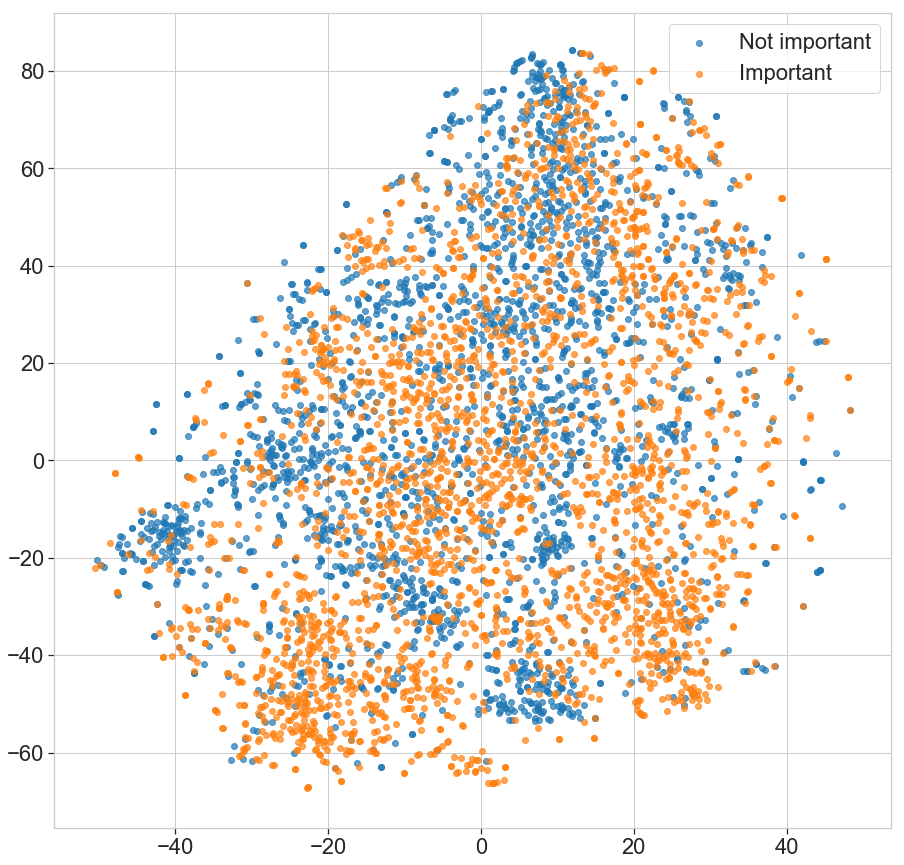

In [421]:
fig, ax = plt.subplots(figsize=(15, 15))
x = X_embedded[:, 0]
y = X_embedded[:, 1]

sup = y_small == 1
ax.scatter(x[sup], y[sup], label='Not important', alpha=0.7)
ax.scatter(x[~sup], y[~sup], label='Important', alpha=0.7)
ax.legend(frameon=True)

In [344]:
vec = documents[1].words
print(vec)

sims = model.docvecs.most_similar([model.docvecs[1]], topn=len(model.docvecs))

#print(sims[0][0])
print(documents[sims[4][0]])


['airborne', 'warning', 'ctl', 'system', 'flight', 'will', 'take', 'place', 'area', '<coord>', '<coord>', '<coord>', '<coord>']
TaggedDocument(['airborne', 'warning', 'ctl', 'system', 'will', 'take', 'place', 'area', '<coord>', '<coord>', '<coord>', '<coord>', 'area', 'clsd', 'tfc', 'btn', 'fl<num>', 'fl<num>'], [61654])


In [317]:
vectors = np.zeros((len(documents), 50))
for i,t in enumerate(documents):
    vectors[i,:] = model.infer_vector(t.words)
    
    
    #print( vectors[i,:])
    #break

In [258]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in corpus]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

from pprint import pprint  # pretty-printer
#pprint(texts)

In [296]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [298]:
vectors = np.zeros((len(texts), 5))
for i,t in enumerate(texts):
    vectors[i,:] = model.infer_vector(t)

In [ ]:
texts[10]

In [268]:


dictionary = corpora.Dictionary(texts)
#print(dictionary.token2id)

In [278]:
#corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [273]:
tfidf = models.TfidfModel(corpus)
tfidf

#index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)

In [282]:
tfidf[corpus[10]]

[(30, 0.06720827110149225),
 (77, 0.10703027966446861),
 (78, 0.24867227945645176),
 (79, 0.3455633128625216),
 (80, 0.1222257253141751),
 (81, 0.3656720578386301),
 (82, 0.32170026033756605),
 (83, 0.29888933903896886),
 (84, 0.09131788555010037),
 (85, 0.36831392715911954),
 (86, 0.12229327552443915),
 (87, 0.40419493285427227),
 (88, 0.3727885343122836)]

TypeError: 'int' object is not iterable

In [353]:
print(list(model.docvecs))

KeyError: "tag '98547' not seen in training corpus/invalid"

In [357]:
vectors = np.zeros((len(documents), 50))
for i,t in enumerate(documents):
    vectors[i,:] = model.docvecs[i]
    
X = vectors


choice = np.random.randint(X.shape[0], size=100)
X_small = X[choice, :]
y_small = df['supress'].values[choice]

# from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_small)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#X_embedded = pca.fit_transform(X_small)

X_embedded.shape

(100, 2)

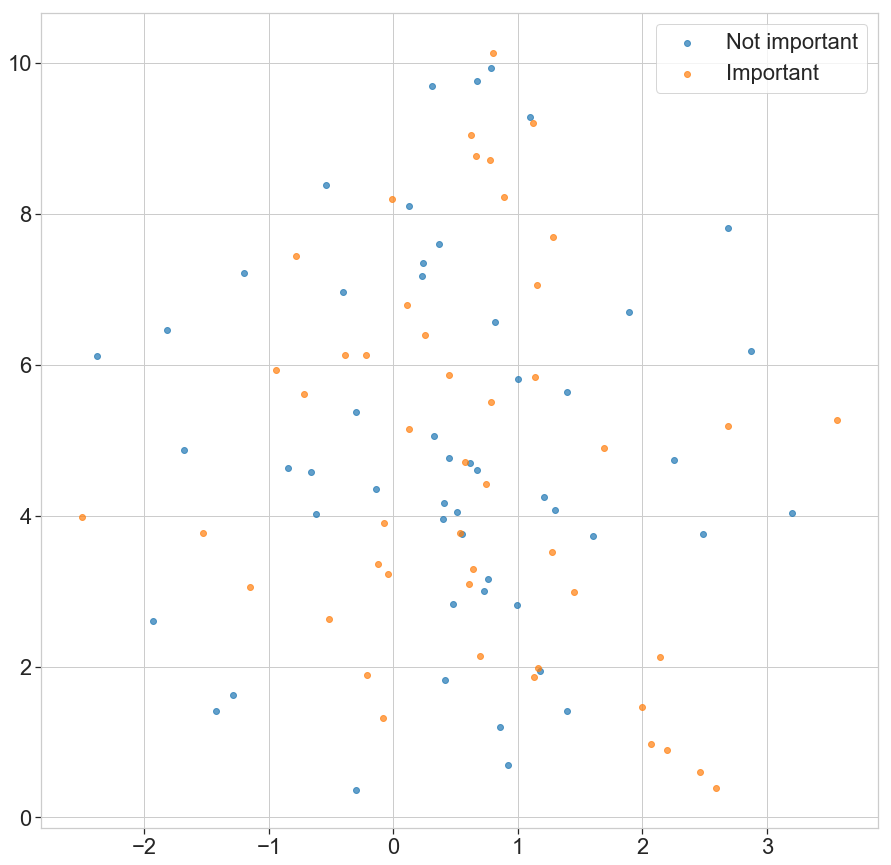

In [360]:
fig, ax = plt.subplots(figsize=(15, 15))
x = X_embedded[:, 0]
y = X_embedded[:, 1]

sup = y_small == 1
ax.scatter(x[sup], y[sup], label='Not important', alpha=0.7)
ax.scatter(x[~sup], y[~sup], label='Important', alpha=0.7)
ax.legend(frameon=True)

In [422]:
text_small = break_lines(df['fulltext'].values[choice])


plotly.offline.init_notebook_mode(connected=True)

#plotly.offline.iplot({
#    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
#    "layout": go.Layout(title="hello world")
#})

trace0 = go.Scatter(
    x = x[sup],
    y = y[sup],
    #z = z[sup],

    name = 'Not important',
    mode = 'markers',
    marker = dict(
        size = 5,
    ),
    text = text_small[sup]
)

trace1 = go.Scatter(
    x = x[~sup],
    y = y[~sup],
    #z = z[sup],
    name = 'Important',
    mode = 'markers',
    marker = dict(
        size = 5,
    ),
    text = text_small[~sup]
)


data = [trace0, trace1]

layout= go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    title= 'NOTAMs/t-SNE',
    hovermode= 'closest',
    xaxis= dict(
        title= 'x',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'y',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)


fig = dict(data=data, layout=layout)
#plotly.offline.iplot(fig)
plotly.offline.plot(fig, filename='NOTAM_t_SNE.html')



'file:///Users/coupon/projects/propulsion/Swiss/3_Modelling/NOTAM_t_SNE.html'